# 3. Modelos e Análises

Nessa etapa serão implementados os modelos de classificação:
    * AdaBoost
    * RandomForest
    * SVM com kernel RBF
    * Regressão Logística com otimização L2

In [37]:
# importações
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 

%matplotlib inline

#### Importação do conjunto de dados
Para avaliação dos modelos será necessário utilizar apenas o conjunto de treinamento. Por ser um desafio do Kaggle, o conjunto de teste é fornecido sem a classe, portanto não é possível obter métricas de validação dos modelos a partir desses dados.

In [88]:
# importa dataset de treino
ids = pd.read_csv('dataset/train_ids.csv')
target = pd.read_csv('dataset/train_target.csv')
features = scipy.sparse.load_npz('dataset/processed_train.npz')

In [89]:
# split em treino e teste
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(features, target, ids, test_size=0.3, shuffle=True)

#### Funções genéricas de treinamento e avaliação dos modelos

In [187]:
def treinamento(X_train, y_train, model_name):
    if model_name=='adaboost':
        model = AdaBoostClassifier()
    if model_name=='randomforest':
        model = RandomForestClassifier()
    if model_name=='svm':
        model = SVC(kernel='rbf',probability=True)
    if model_name=='logreg':
        model = LogisticRegression(penalty='l2', dual=True, C=0.3)
    
    model.fit(X_train,y_train)
    
    return model

In [136]:
def predict(X_test, model):
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)
    return pred, proba

In [181]:
def validation(X_test, y_test, proba, pred, model, model_name):
    #plt.ylabel('Feature Importance Score')
    with open(model_name+'_validation.txt', 'w') as f:
        print('Accuracy of the '+model_name+' on test set: {:.3f}'.format(model.score(X_test, y_test['target'])))
        print('Accuracy of the '+model_name+' on test set: {:.3f}'.format(model.score(X_test, y_test['target'])), file=f)

        print(metrics.classification_report(y_test['target'], pred))
        print(metrics.classification_report(y_test['target'], pred), file=f)

        print('F-score: '+str(metrics.f1_score(y_test['target'],pred)))
        print('F-score: '+str(metrics.f1_score(y_test['target'],pred)), file=f)
        
        fpr, tpr, thresholds = metrics.roc_curve(pred, y_test['target'])
        print('AUC: ' + str(metrics.auc(fpr, tpr)))
        print('AUC: ' + str(metrics.auc(fpr, tpr)), file=f)
        
        cm = metrics.confusion_matrix(y_test, pred)
        print(pd.DataFrame({'Real Não Confiável': [cm[0,0],cm[1,0]],'Real Confiável': [cm[0,1],cm[1,1]]},index=['Predict Não Confiável', 'Predict Confiável']))
        print(pd.DataFrame({'Real Não Confiável': [cm[0,0],cm[1,0]],'Real Confiável': [cm[0,1],cm[1,1]]},index=['Predict Não Confiável', 'Predict Confiável']), file=f)
    return None

def plot_roc_curve(y_score, y_true, model_name):
    fpr,tpr,thr = metrics.roc_curve(y_score=y_score,y_true=y_true)
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="best")
    plt.savefig(model_name+'_roc_curve.png')
    return fpr,tpr,thr

def ks_test(decision, y_test, model_name):
    scores = pd.DataFrame(
        {'scores': decision,
         'y': y_test
         })
    bad = scores[scores['y']==0]
    good = scores[scores['y']==1]
    
    valuesb, baseb = np.histogram(bad['scores'],2000)
    valuesg, baseg = np.histogram(good['scores'],2000)
    
    ks = scipy.stats.ks_2samp(bad['scores'], good['scores'])
    print(ks)
    # evaluate the cumulative
    cumulativeB = np.cumsum(valuesb)
    cumulativeG = np.cumsum(valuesg)
    cumBperc = (cumulativeB / cumulativeB[-1]) * 100
    cumGperc = (cumulativeG / cumulativeG[-1]) * 100

    # plot the cumulative function
    plt.figure()
    plt.plot(baseb[:-1], cumBperc, c='blue', label='Bad')
    plt.plot(baseg[:-1], cumGperc, c='green', label='Good')
    plt.title('Kolmogorov–Smirnov Test')
    text = 'KS = %0.2f' % ks.statistic
    plt.text(0.05, 90, text)
    plt.savefig(model_name+'_ks_test.png')
    # https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html
    print(text)

### Adaboost

In [157]:
model_name = 'adaboost'
model = treinamento(X_train, y_train.values.ravel(), model_name)

In [158]:
pred, proba = predict(X_test, model)

In [159]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the adaboost on test set: 0.960
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3176
           1       0.96      0.96      0.96      2926

   micro avg       0.96      0.96      0.96      6102
   macro avg       0.96      0.96      0.96      6102
weighted avg       0.96      0.96      0.96      6102

F-score: 0.9579774513153398
AUC: 0.9596064850682285
                       Real Não Confiável  Real Confiável
Predict Não Confiável                3052             124
Predict Confiável                     122            2804


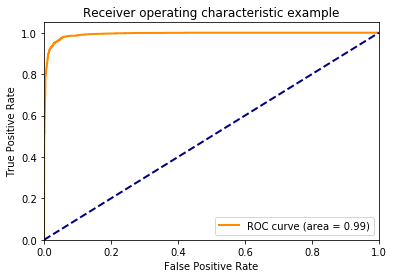

In [161]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.9231798295831174, pvalue=0.0)
KS = 0.92


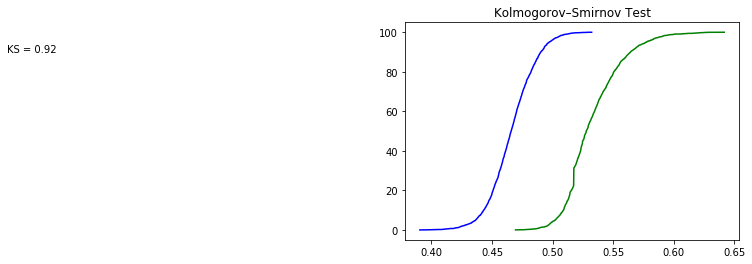

In [162]:
ks_test(proba[:,1],y_test['target'], model_name)

### Random Forest

In [163]:
model_name = 'randomforest'
model = treinamento(X_train, y_train.values.ravel(), model_name)

c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [164]:
pred, proba = predict(X_test, model)

In [165]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the randomforest on test set: 0.851
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      3176
           1       0.89      0.78      0.83      2926

   micro avg       0.85      0.85      0.85      6102
   macro avg       0.86      0.85      0.85      6102
weighted avg       0.86      0.85      0.85      6102

F-score: 0.8336373586282377
AUC: 0.8566039496993239
                       Real Não Confiável  Real Confiável
Predict Não Confiável                2905             271
Predict Confiável                     641            2285


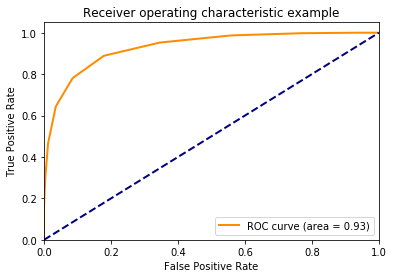

In [166]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.7100586507486946, pvalue=0.0)
KS = 0.71


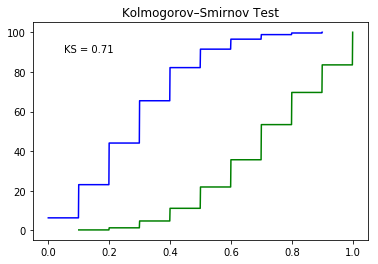

In [167]:
ks_test(proba[:,1],y_test['target'], model_name)

### SVM

In [188]:
model_name = 'svm'
model = treinamento(X_train, y_train.values.ravel(), model_name)

In [189]:
pred, proba = predict(X_test, model)

In [190]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the svm on test set: 0.520
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      3176
           1       0.00      0.00      0.00      2926

   micro avg       0.52      0.52      0.52      6102
   macro avg       0.26      0.50      0.34      6102
weighted avg       0.27      0.52      0.36      6102

F-score: 0.0
AUC: nan
                       Real Não Confiável  Real Confiável
Predict Não Confiável                3176               0
Predict Confiável                    2926               0


c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\prisk\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


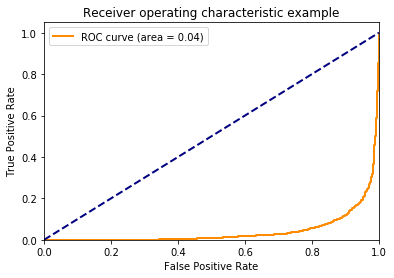

In [191]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

In [192]:
ks_test(proba[:,1],y_test['target'], model_name)

Ks_2sampResult(statistic=0.7829829755290447, pvalue=0.0)
KS = 0.78


ValueError: Image size of 506970x264 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

### Logistic Regression

In [176]:
model_name = 'logreg'
model = treinamento(X_train, y_train.values.ravel(), model_name)

In [177]:
pred, proba = predict(X_test, model)

In [178]:
validation(X_test, y_test, proba, pred, model, model_name)

Accuracy of the logreg on test set: 0.937
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3176
           1       0.92      0.95      0.93      2926

   micro avg       0.94      0.94      0.94      6102
   macro avg       0.94      0.94      0.94      6102
weighted avg       0.94      0.94      0.94      6102

F-score: 0.9349251723558096
AUC: 0.9364189395426433
                       Real Não Confiável  Real Confiável
Predict Não Confiável                2935             241
Predict Confiável                     146            2780


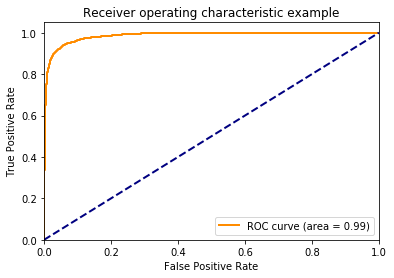

In [179]:
fpr,tpr,thr = plot_roc_curve(proba[:,1], y_test['target'], model_name)

Ks_2sampResult(statistic=0.8815464497056701, pvalue=0.0)
KS = 0.88


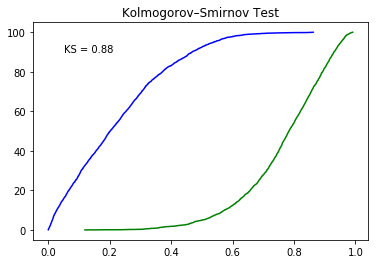

In [182]:
ks_test(proba[:,1],y_test['target'], model_name)